# Task1: Play with 3RScan dataset

In [42]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import matplotlib.image as mpimg
import re
from PIL import Image

# # monkey patched visualization and provides helpers to load geometries
# sys.path.append('..')
# import open3d_example as o3dtut
# # change to True if you want to interact with the visualization windows
# o3dtut.interactive = not "CI" in os.environ

## RGBD images
Open3D has a data structure for images. It supports various functions such as `read_image`, `write_image`, `filter_image` and `draw_geometries`. An Open3D Image can be directly converted to/from a numpy array/

An Open3D `RGBDImage` is composed of two images, `RGBDImage.depth` and `RGBDImage.color`. We require the two images to be registered into the same camera frame and have the same resolution.

Note: 3RScan has a drawback, rgb & d images are not of same resolution.

((224, 172), (224, 172), <matplotlib.image.AxesImage at 0x7feb5aef8ca0>)

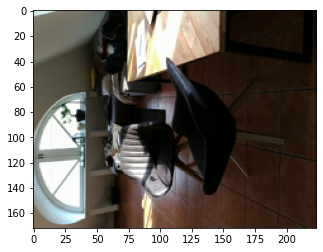

In [43]:
rgb = Image.open("./demo/sequence/frame-000000.color.jpg")
d = Image.open("./demo/sequence/frame-000000.depth.pgm")
# rgb.size, d.size
resized_rgb = rgb.resize(d.size)
resized_rgb.save('resized_rgb.jpg')
resized_rgb.size, d.size, plt.imshow(resized_rgb)

$RGB+D=RGBD$

In [44]:
# This is special function used for reading pgm format
# as it is written in big endian byte order.
def read_pgm(filename, byteorder='>'):
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    img = np.frombuffer(buffer,
                        dtype=byteorder + 'u2',
                        count=int(width) * int(height),
                        offset=len(header)).reshape((int(height), int(width)))
    img_out = img.astype('u2')
    return img_out

# Open3D does not support ppm/pgm file yet. Not using o3d.io.read_image here.
# MathplotImage having some ISSUE with pgm file. Not using imread for pgm.
print("Read a single shot from 3RScan dataset!")
color_raw = o3d.io.read_image("resized_rgb.jpg")
depth_raw = read_pgm("./demo/sequence/frame-000000.depth.pgm")
depth = o3d.geometry.Image(depth_raw)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth)
print(rgbd_image)

Read a single shot from 3RScan dataset!
RGBDImage of size 
Color image : 224x172, with 1 channels.
Depth image : 224x172, with 1 channels.
Use numpy.asarray to access buffer data.


The default conversion function `create_rgbd_image_from_color_and_depth` creates an RGBDImage from a pair of color and depth image. The color image is converted into a grayscale image, stored in `float` ranged in [0,1]. The depth image is stored in `float`, representing the depth value in meters.

The converted images can be rendered as numpy arrays.

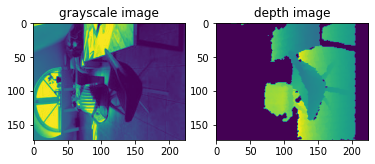

In [46]:
plt.subplot(1, 2, 1)
plt.title('grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('depth image')
plt.imshow(rgbd_image.depth)
plt.show()

The RGBD image can be converted into a point cloud, given a set of camera parameters.

### Default camera information

In [47]:
o3d.camera.PinholeCameraIntrinsic(
    o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault) \
, o3d.camera.PinholeCameraIntrinsic(
    o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault).intrinsic_matrix

(PinholeCameraIntrinsic with width = 640 and height = 480.
 Access intrinsics with intrinsic_matrix.,
 array([[525. ,   0. , 319.5],
        [  0. , 525. , 239.5],
        [  0. ,   0. ,   1. ]]))

## 3RScan Camera Information
### I/O

In [48]:
info = open("./demo/sequence/_info.txt","r+")
info.seek(0)
info_lines = info.readlines()
c_w = int(info_lines[2].split()[-1])
c_h = int(info_lines[3].split()[-1])
d_w = int(info_lines[4].split()[-1])
d_h = int(info_lines[5].split()[-1])
c_in = np.array([float(i) for i in info_lines[7].split()[2:]]).reshape(4,-1)[:3,:3]
d_in = np.array([float(i) for i in info_lines[9].split()[2:]]).reshape(4,-1)[:3,:3]
print("color width: {}\n".format(c_w))
print("color height: {}\n".format(c_h))
print("color intrinsic:\n{}\n".format(c_in))
print("depth width: {}\n".format(d_w))
print("depth height: {}\n".format(d_h))
print("depth intrinsic:\n{}\n".format(d_in))
info.close()

color width: 960

color height: 540

color intrinsic:
[[756.832   0.    492.889]
 [  0.    756.026 270.419]
 [  0.      0.      1.   ]]

depth width: 224

depth height: 172

depth intrinsic:
[[176.594    0.     114.613 ]
 [  0.     240.808   85.7915]
 [  0.       0.       1.    ]]



### Set open3d.camera.PinholeCameraIntrinsic

In [49]:
c_cem_in = o3d.camera.PinholeCameraIntrinsic(width=c_w, height=c_h, 
                                           fx=c_in[0,0], fy=c_in[1,1], 
                                           cx=c_in[0,2], cy=c_in[1,2])
d_cem_in = o3d.camera.PinholeCameraIntrinsic(width=d_w, height=d_h, 
                                           fx=d_in[0,0], fy=d_in[1,1], 
                                           cx=d_in[0,2], cy=d_in[1,2])

In [50]:
d_cem_in, d_cem_in.intrinsic_matrix

(PinholeCameraIntrinsic with width = 224 and height = 172.
 Access intrinsics with intrinsic_matrix.,
 array([[176.594 ,   0.    , 114.613 ],
        [  0.    , 240.808 ,  85.7915],
        [  0.    ,   0.    ,   1.    ]]))

## Point cloud

In [51]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, d_cem_in)
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
print(pcd)
print(np.asarray(pcd.points))
o3d.visualization.draw_geometries([pcd])

PointCloud with 17953 points.
[[-1.21670133  0.82653514 -2.31999993]
 [-1.20356385  0.82653514 -2.31999993]
 [-1.21505593  0.8436359  -2.36800003]
 ...
 [ 0.77975965 -0.56402755 -1.59399998]
 [ 0.78878601 -0.56402755 -1.59399998]
 [ 0.44395207 -0.31385976 -0.88700002]]


## Crop & Bounding Box (failed)

In [32]:
# vol = o3d.visualization.read_selection_polygon_volume("./demo.json")
# chair = vol.crop_point_cloud(pcd)
# o3d.visualization.draw_geometries([chair],
#                                   zoom=0.7,
#                                   front=[0.5439, -0.2333, -0.8060],
#                                   lookat=[2.4615, 2.1331, 1.338],
#                                   up=[-0.1781, -0.9708, 0.1608])

[Open3D WARNING] Read JSON failed: unable to open file: ./demo.json


# Task2: Play with NetVLAD

work adopted from https://github.com/lyakaap/NetVLAD-pytorch

In [53]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from netvlad import NetVLAD
from netvlad import EmbedNet
from hard_triplet_loss import HardTripletLoss
from torchvision.models import resnet18


# Discard layers at the end of base network
encoder = resnet18(pretrained=True)
base_model = nn.Sequential(
    encoder.conv1,
    encoder.bn1,
    encoder.relu,
    encoder.maxpool,
    encoder.layer1,
    encoder.layer2,
    encoder.layer3,
    encoder.layer4
)
dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)

# Define model for embedding
net_vlad = NetVLAD(num_clusters=4, dim=dim, alpha=1.0)
model = EmbedNet(base_model, net_vlad)

# Define loss
criterion = HardTripletLoss(margin=0.1)

# This is just toy example. Typically, the number of samples in each classes are 4.
# labels = torch.randint(0, 10, (40, )).float()
x = torch.rand(1, 3, 128, 128)
# output = model(x)

# triplet_loss = criterion(output, labels)
model(x).shape, model(x)

(torch.Size([1, 2048]),
 tensor([[-0.0072, -0.0126, -0.0044,  ..., -0.0168, -0.0004, -0.0385]],
        grad_fn=<DivBackward0>))